In [35]:
# Import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels.api as sm

# Read in dataset
df = pd.read_csv("bank_data.csv")

# Print the first few rows of the DataFrame
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


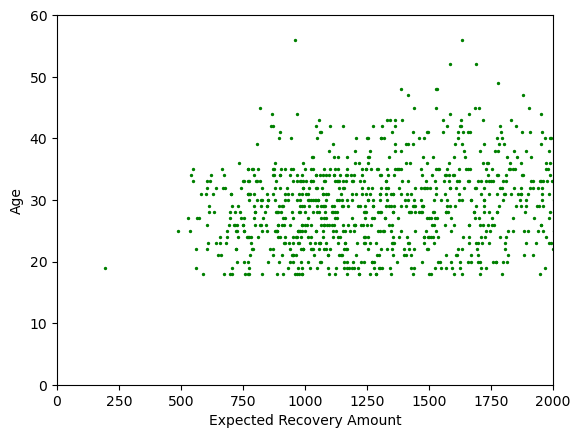

In [36]:
# Create scatter plot of Age vs. Expected Recovery Amount 
plt.scatter(x=df['expected_recovery_amount'], y=df['age'], c="g", s=2)
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.show()

In [37]:
# There is no major jump in the customer age just above and below the $1000 threshold.

In [38]:
# Subset expected recovery amount just below and above the threshold for Level 1 recovery
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]

# Perform Kruskal-Wallis test to determine if the difference in customer age just above and below threshold is significant (significance threshold = 0.05) 
Level_0_age = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]["age"]
Level_1_age = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]["age"]
stats.kruskal(Level_0_age,Level_1_age)

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

In [39]:
# p-value is higher than the signifcance threshold, which confirms the difference in age just above and below the threshold is not significant.

In [40]:
# Develop crosstab to check if sex varies significantly just above and below the threshold
crosstab = pd.crosstab(df.loc[(df["expected_recovery_amount"]<1100) & 
                              (df["expected_recovery_amount"]>=900)]['recovery_strategy'], 
                       df['sex'])
crosstab

sex,Female,Male
recovery_strategy,,
Level 0 Recovery,32,57
Level 1 Recovery,39,55


In [41]:
# Perform chi-square test of independence to detemrine if difference in sex is significant (significance threshold = 0.05) 
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
p_val

0.5377947810444592

In [42]:
# p-value is higher than the signifcance threshold, which confirms the difference in sex just above and below the threshold is not significant.

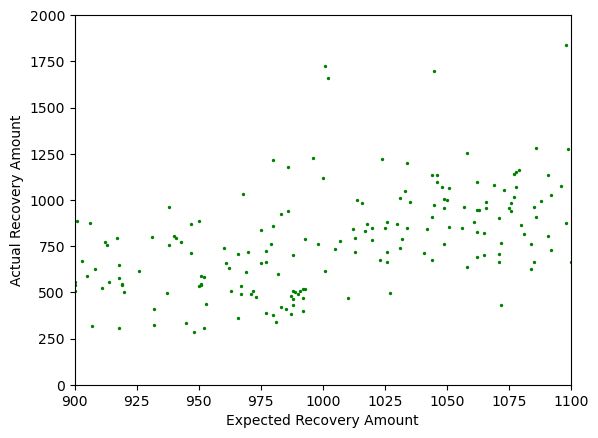

In [43]:
# Create scatter plot of Expected Recovery Amount versus Actual Recovery Amount for Expected Recovery Amounts between $900 to $1100 (just before and after threshold 1) 

plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="g", s=2)
plt.xlim(900,1100)
plt.ylim(0,2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.show()

In [44]:
# There doesn't seem to be a jump (discontinuity) around threshold 1.  

In [45]:
# Check if difference in actual recovery amount is statistically significant with Kruskal-Wallis test

Level_0_actual = era_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual,Level_1_actual) 

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)

In [46]:
# Run the same test for a narrower range around threshold 1

era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]

Level_0_actual = era_950_1050.loc[df['recovery_strategy']=="Level 0 Recovery"]['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[df['recovery_strategy']=="Level 1 Recovery"]['actual_recovery_amount']
stats.kruskal(Level_0_actual,Level_1_actual) 

KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

In [47]:
# Build linear regression model which predicts the actual recovery amount (dependent variable) as a function of the expected recovery amount (independent variable).

X = era_900_1100['expected_recovery_amount']
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

In [48]:
# Print summary statistics of the model 
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Fri, 16 Feb 2024   Prob (F-statistic):           1.56e-13
Time:                            12:06:15   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [49]:
# The expected recovery amount's regression coefficient is statistically significant

In [50]:
# Create an indicator variable (either a 0 or a 1) that represents whether or not the expected recovery amount was greater than $1000.
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)

# Subset expected recovery amount just below and above the threshold for Level 1 recovery (including newly created column)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]

In [51]:
#  Build another linear regression model including the indicator
X = era_900_1100[['expected_recovery_amount', 'indicator_1000']]
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()

In [52]:
# Print summary statistics of the model 
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Fri, 16 Feb 2024   Prob (F-statistic):           1.83e-15
Time:                            12:06:15   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [53]:
# The regression coefficient of the true threshold (indicator) is statistically significant, with an estimated impact of $278.This is much larger than the $50 per customer needed to run this higher recovery strategy.

In [54]:
# Repeat the analysis for a narrower range around threshold 1 to validate results
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]

X = era_950_1050[['expected_recovery_amount', 'indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

model = sm.OLS(y,X).fit()

print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Fri, 16 Feb 2024   Prob (F-statistic):           1.12e-07
Time:                            12:06:15   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------